In [89]:
library("Mfuzz")
library(ggpubr)
o<-function(w,h) options(repr.plot.width=w, repr.plot.height=h)

mFuzz.ggplot <- function(data, clustering, 
                         centre = TRUE, sort.columns = TRUE,
                         given.order=NA,nrow=2, ncol=4
                        ) {
    # from https://github.com/jspaezp/mFuzzOptim/blob/master/ggMfuzzplot.R    
    require(ggplot2)
    require(dplyr)
    require(tidyr)
    
    clusterindex <- clustering$cluster
    
    # data frame with Membership values
    memship <- clustering$membership 
    colnames(memship) <- paste("membership", 
        seq_along(memship[1,]), 
        sep = ("")) 
    
    exp <- exprs(data)
    
    # This chunk replaces col names by numbers if 
    # more than 1 is character only 
    # or when sort.columns is FALSE
    
    all.char.cols <- !grepl("\\d", colnames(exp))
    if ((sum(all.char.cols) > 1) | !sort.columns) {
        colnames(exp) <- seq_along(all.char.cols)    
    }
    
    exp <- data.frame(exp , 
            Identifier = rownames(data),
            clusterindex, memship) 
    
    # Transform data frame into a ggplot-compatible format
    exp <- exp %>% 
        gather(sample, 
            expression ,
            - Identifier,
            - clusterindex,
            - contains("membership")) %>% 
        mutate(Time = gsub("(\\w*\\D+(?=([0-9]+)))|((?<=\\d)\\D+$)", 
                "", 
                sample,
                perl = TRUE)) %>%
        #  this regular expression deletes all characters and numbers prior to 
        #  the last number in the string z.b. AA00AA00__00 -> 00 else keeps the string
        mutate(Time = gsub("^\\D*$", # this needs to be fixed, bug when seveal character cols ...
                "0", 
                Time,
                perl = TRUE)) %>%
        mutate(Time = as.numeric(Time))
    
    exp[["maxMembership"]] <- exp %>%  
        dplyr::select(contains("membership")) %>%
        apply(., 1, max) 
    
    
    #exp<- exp %>% filter(maxMembership>0.6) # filter here
    
    
    g <- ggplot(data = exp, aes(x = Time, y = expression)) +
        geom_line(aes(group = Identifier,  
                  colour = maxMembership, 
                  order = rank(maxMembership))) + 
        scale_colour_gradientn(colours = heat.colors(10, alpha=0.1))+ # change palette here
        #scale_colour_gradientn(colours = rainbow(5, alpha = 0.4)) 
        theme_pubr()
        
    
    # Center line plotting when centre == TRUE
    if (centre) {
        centers <- clustering$centers %>% 
                    data.frame(., clusterindex = rownames(.)) %>% 
                    gather(sample, Centre, - clusterindex) %>% 
                    mutate(Time = gsub("(\\w*\\D+(?=([0-9]+)))|((?<=\\d)\\D+$)", 
                            "", sample, perl = TRUE)) %>%
                    #  this regular expression deletes all characters and numbers prior to 
                    #  the last number in the string z.b. AA00AA00__00 -> 00 else keeps the string
                    mutate(Time = gsub("^\\D*$", # this needs to be fixed, bug when all character names
                            "0", Time, perl = TRUE)) %>%
                    mutate(Time = as.numeric(Time))
        
        g <- g + geom_line(data = centers, aes(x = Time, y = Centre))
    }
         
    
    g <- ggpubr::facet(g, facet.by = "clusterindex",
               nrow=nrow, ncol = ncol,scales='free',
               short.panel.labs = T,   # Allow long labels in panels
               panel.labs.background = list(fill = "lightgray", color = "lightgray"),
               strip.position='top'
    )
    
    #g <- g + facet_wrap(~clusterindex, ncol = 4,nrow=2)
    
    return(g)
} 

In [90]:
ilcp.hvg = read.csv('ilcp.hvg.csv')[,2]
alp1.hvg = read.csv('alp1.hvg.csv')[,2]

In [91]:
tf1=read.table("https://ghproxy.com/https://github.com/chansigit/SSAT/raw/master/mm.tf.csv",sep='\t')$x
tf2=read.table('https://www.grnpedia.org/trrust/data/trrust_rawdata.mouse.tsv',sep="\t")$V1
tf = unique(c(tf1,tf2))
length(tf)

[1] 1874

In [ ]:
suppressPackageStartupMessages({
library(clusterProfiler)
library(org.Mm.eg.db)
library(enrichplot)
})

d <- GOSemSim::godata('org.Mm.eg.db', ont="BP")

preparing gene to GO mapping data...



# FL analysis

## load data

In [ ]:
# 1. load data
o(5,5)
goi = ilcp.hvg
mat = read.csv('./221112-FL-ILCprimed-PathExpr.csv', row.names = 1)
colnames(mat) <- paste("T",0:(ncol(mat)-1), sep='')
mat = mat[ intersect(goi,rownames(mat)), ]
eset <- new("ExpressionSet",exprs = as.matrix(mat))
eset <- filter.std(eset,min.std=0.04) # filter data
eset <- standardise(eset)

## param est

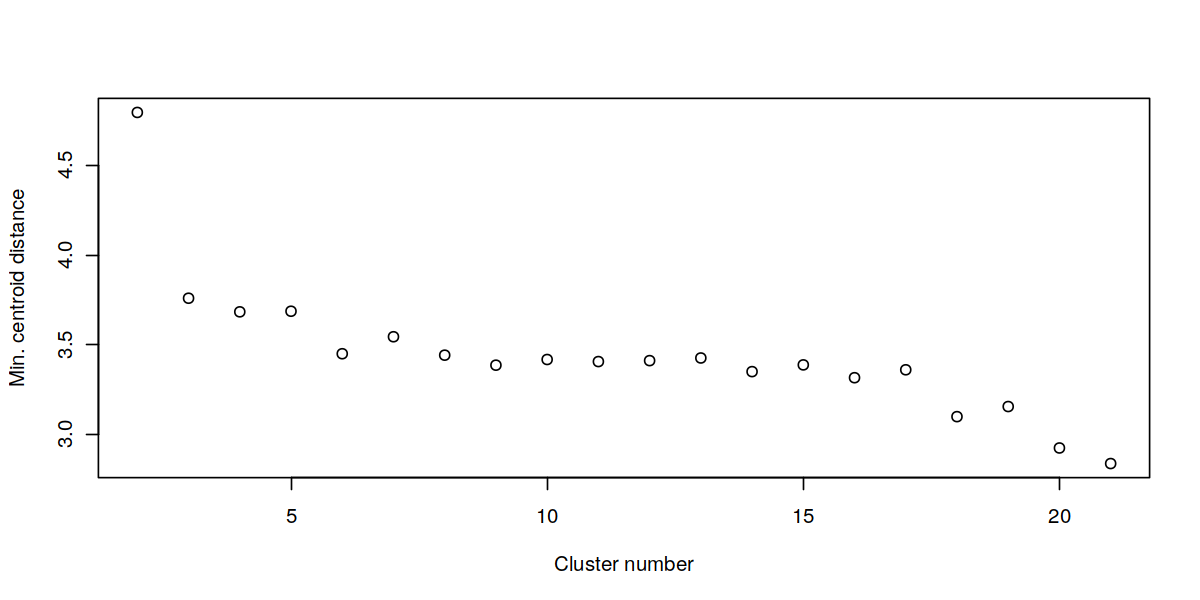

In [6]:
# 2. parameter estimation
m <- mestimate(eset)

# Find minimal distances among cluster centroids
o(10,5)
param.trial <-Dmin(eset, m=m, crange=seq(2,21,1), repeats=5, visu=T)

## do clustering

Loading required package: dplyr


Attaching package: ‘dplyr’


The following object is masked from ‘package:AnnotationDbi’:

    select


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following object is masked from ‘package:widgetTools’:

    funs


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tidyr


Attaching package: ‘tidyr’


The following object is masked from ‘package:S4Vectors’:

    expand


Warning message:
“Ignoring unknown aesthetics: order”


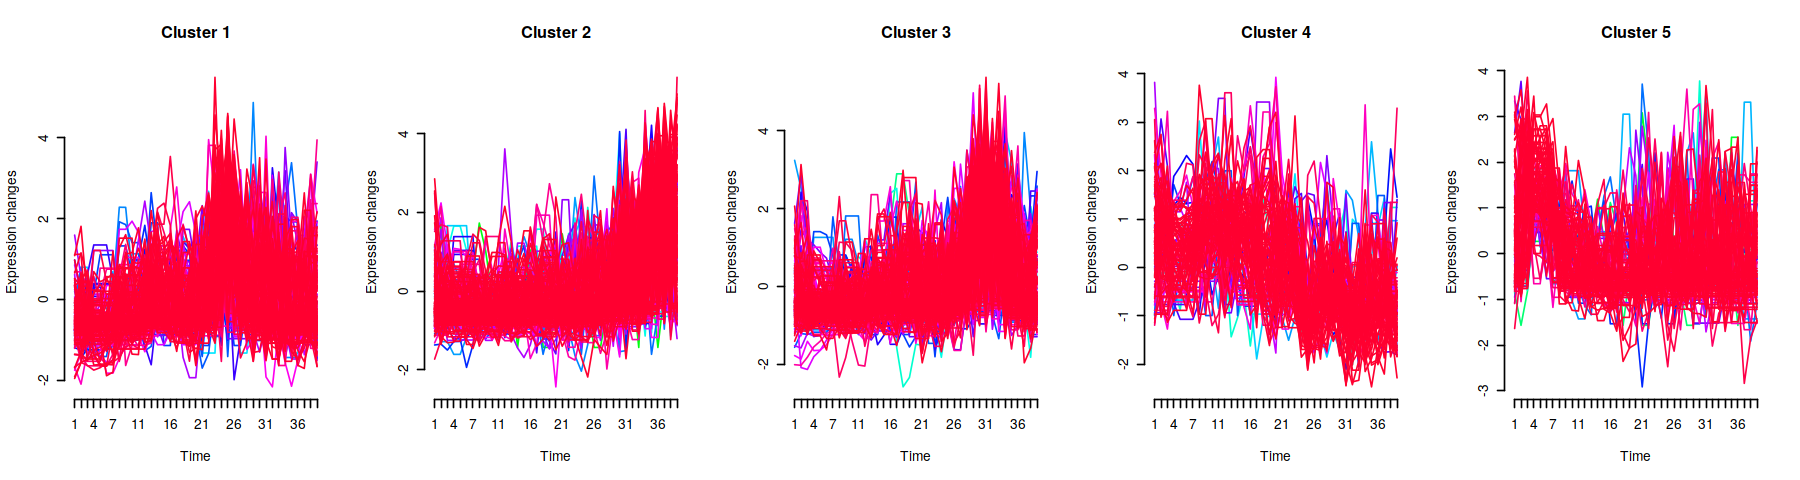

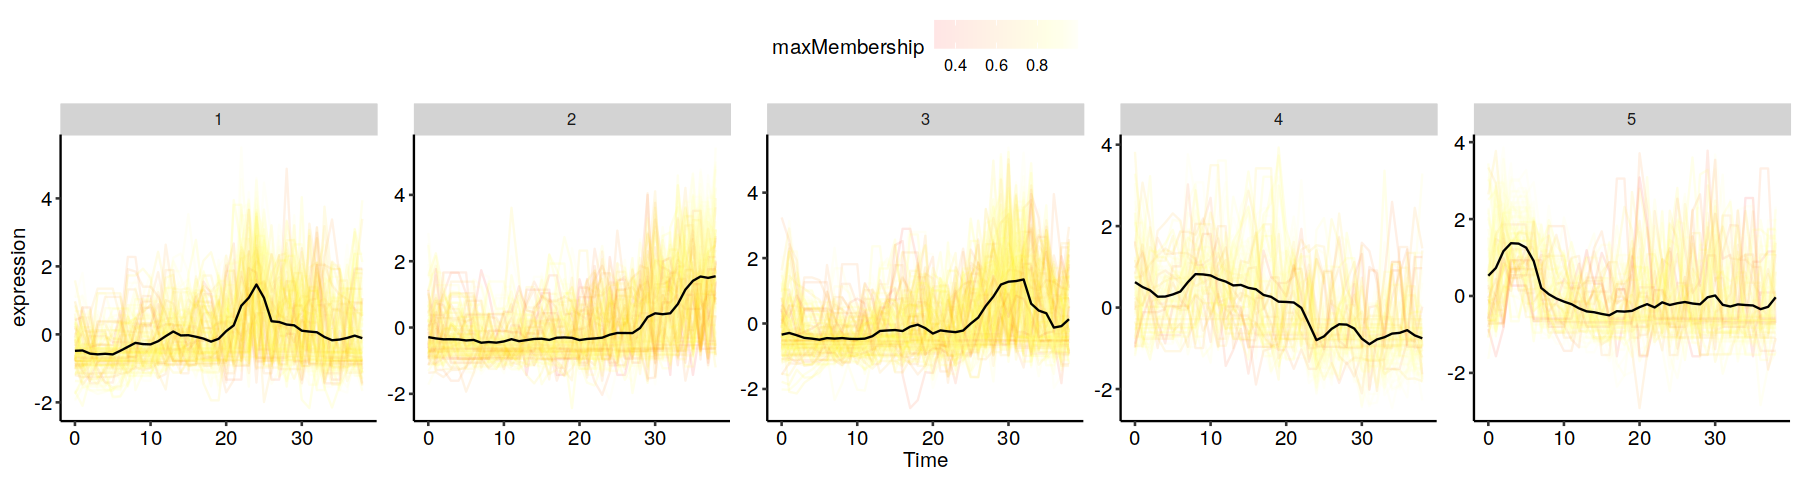

In [7]:
# 3. do clustering and show
c <- 5 # number of clusters
cl <- mfuzz(eset, c = c, m = m) # do clustering

o(3*5,4*1)
mfuzz.plot( eset,cl,mfrow=c(1,5), new.window= FALSE)


o(3*5, 4*1)
mFuzz.ggplot(eset, cl, centre = T, nrow=1,ncol=5)

In [8]:
# 4. extract cluster information
# find number of genes in each cluster
cl$size

# extract genes within a certain cluster
cluster_gene <- as.data.frame(cl$cluster)
colnames(cluster_gene)<-'GeneCluster'
cluster_gene <- cluster_gene %>% mutate(gene = rownames(.))

# Find gene-cluster memberships
membership   <- cl$membership
colnames(membership) <-paste('BelongToGC',colnames(membership), sep='')
membership <- membership %>% as.data.frame %>% mutate(gene= rownames(.))

[1] 161 226 224 100 113

In [9]:
# 5. explain clusters

get_cluster_genes<- function(membership, cluster, cutoff){
    df = membership[, cluster,drop=F]
    colnames(df) <- 'affinity'
    df <- df %>% filter(affinity>cutoff) %>% arrange(desc(affinity))
    rownames(df)
}

In [10]:
c1.gene    <- get_cluster_genes(membership, 1, cutoff = 0.6)
gene.df    <- bitr(c1.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db)
enrich.res <- enrichGO(gene= gene.df$ENSEMBL, readable=T,
                OrgDb         = org.Mm.eg.db,
                keyType       = 'ENSEMBL',
                ont           = "BP",
                pAdjustMethod = "BH",pvalueCutoff  = 0.05,qvalueCutoff  = 0.05)
c1.enrich.res  <- pairwise_termsim(enrich.res, method="Wang", semData=d)
c1.enrich.tree <- treeplot(c1.enrich.res)

c2.gene    <- get_cluster_genes(membership, 2, cutoff = 0.6)
gene.df    <- bitr(c2.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db)
enrich.res <- enrichGO(gene= gene.df$ENSEMBL, readable=T,
                OrgDb         = org.Mm.eg.db,
                keyType       = 'ENSEMBL',
                ont           = "BP",
                pAdjustMethod = "BH",pvalueCutoff  = 0.05,qvalueCutoff  = 0.05)
c2.enrich.res  <- pairwise_termsim(enrich.res, method="Wang", semData=d)
c2.enrich.tree <- treeplot(c2.enrich.res)

c3.gene    <- get_cluster_genes(membership, 3, cutoff = 0.6)
gene.df    <- bitr(c3.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db)
enrich.res <- enrichGO(gene= gene.df$ENSEMBL, readable=T,
                OrgDb         = org.Mm.eg.db,
                keyType       = 'ENSEMBL',
                ont           = "BP",
                pAdjustMethod = "BH",pvalueCutoff  = 0.05,qvalueCutoff  = 0.05)
c3.enrich.res  <- pairwise_termsim(enrich.res, method="Wang", semData=d)
c3.enrich.tree <- treeplot(c3.enrich.res)

c4.gene    <- get_cluster_genes(membership, 4, cutoff = 0.6)
gene.df    <- bitr(c4.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db)
enrich.res <- enrichGO(gene= gene.df$ENSEMBL, readable=T,
                OrgDb         = org.Mm.eg.db,
                keyType       = 'ENSEMBL',
                ont           = "BP",
                pAdjustMethod = "BH",pvalueCutoff  = 0.05,qvalueCutoff  = 0.05)
c4.enrich.res  <- pairwise_termsim(enrich.res, method="Wang", semData=d)
c4.enrich.tree <- treeplot(c4.enrich.res)

c5.gene    <- get_cluster_genes(membership, 5, cutoff = 0.6)
gene.df    <- bitr(c5.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db)
enrich.res <- enrichGO(gene= gene.df$ENSEMBL, readable=T,
                OrgDb         = org.Mm.eg.db,
                keyType       = 'ENSEMBL',
                ont           = "BP",
                pAdjustMethod = "BH",pvalueCutoff  = 0.05,qvalueCutoff  = 0.05)
c5.enrich.res  <- pairwise_termsim(enrich.res, method="Wang", semData=d)
c5.enrich.tree <- treeplot(c5.enrich.res)



'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(c1.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“5.26% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(c2.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“3.79% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(c3.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“4.83% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(c4.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“7.45% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(c5.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“1.94% of input gene IDs are f

# Analysis results

In [ ]:
o(3*4, 4*1)
mFuzz.ggplot(eset, cl, centre = T, nrow=1,ncol=5)

## G5 (Peak T =3)

[1] "Genes:"
Ms4a6c Stfa1 Glipr1 Elane Unc93b1 Dph6 Sik1 Hp Ebi3 Irf8 Il21r Dusp2 Ankfy1 Clec12a Cebpb Samsn1 Mt1 H2-DMa Rinl Naga Cst3 Ctsg Pld4 Bex6 Ly86 Prtn3 Cited2 Fam234a Tatdn1 Inafm1 Mndal Tmem80 Abhd2 Ccdc102a Ccdc71l Spi1 Hdc Cd69 H2-DMb2 Enpp4 Ifi203 Wfdc17 Mpo Ap3s1 Taf1d Samhd1 Emb Lst1 H2-DMb1 Crot Serpinb1a BC035044 Tmem176b 1700097N02Rik Emilin2 Cyth4 P2rx4 Myo1f Myh9 Ccnd2 Emc9 Tmem158 Fth1 Hspa5 Prkch Cd24a Ccl3 Prss2 Hk2 Sirt2 Gpx1 Snx20 Mef2c Flt3 Kmo Eno3 B930036N10Rik Pim1 Ccl9 Gpr183 Ctsc Lmo2 Cox6a2 Gna13 H1fx Chd7 Slc16a3 Notch2 Ptpre Mcpt8 Slc25a20 Isg20 Hbb-bs Rgcc Basp1 Terf2ip Ctsh Lmnb1 Ctsl Egfl7 Lockd Cyba Dgat1NULL
[1] "TFs:"
Irf8 Cebpb Cited2 Spi1 Mef2c Lmo2 Chd7 Notch2NULL


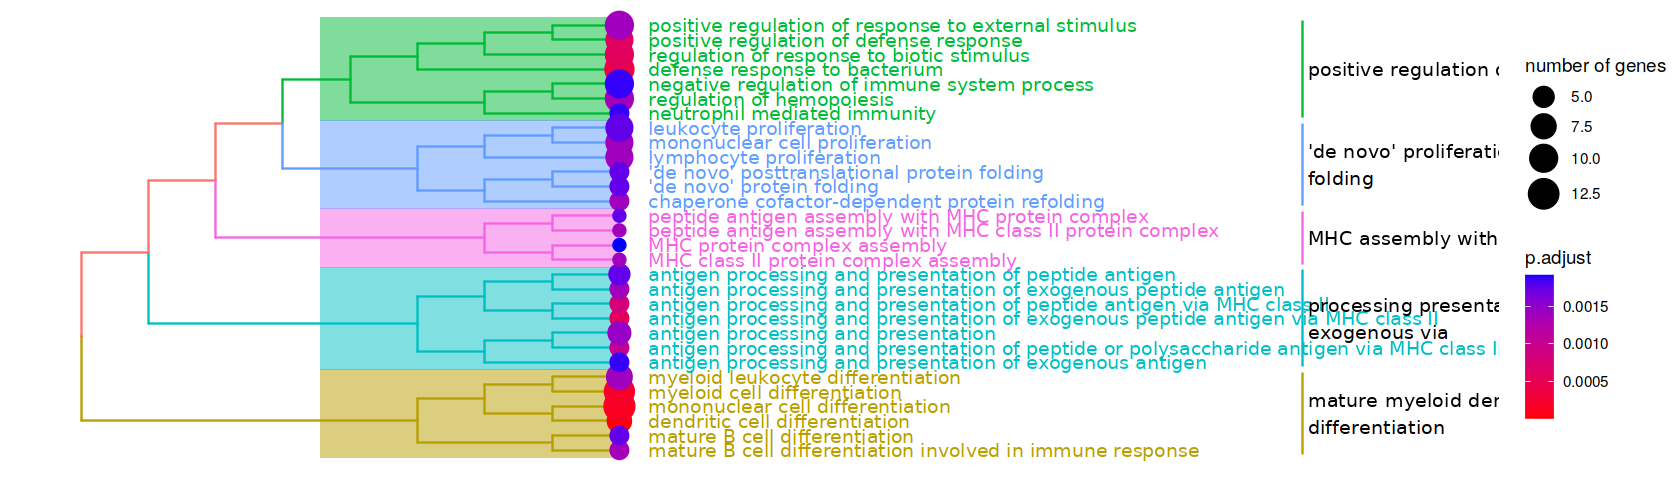

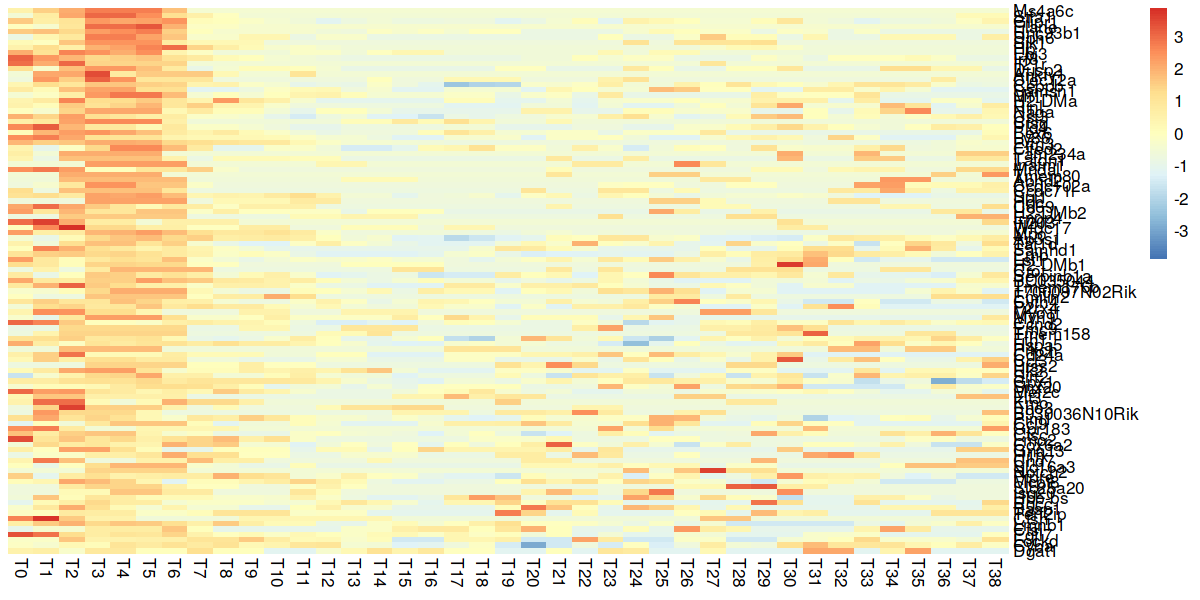

In [18]:

print('Genes:')
print(cat(c5.gene))

print('TFs:')
print(cat(intersect(c5.gene, tf)))

o(14,4)
plot(c5.enrich.tree)

library(pheatmap)
o(10,5)
pheatmap(mat[c5.gene,], scale = 'row', 
         cluster_rows = F, cluster_cols = F, border_color=NA)

In [19]:
data.frame(c5.enrich.res)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0097028,GO:0097028,dendritic cell differentiation,7/96,44/22853,6.238125e-10,1.416678e-06,1.119579e-06,Irf8/Cebpb/Prtn3/Spi1/Tmem176b/Flt3/Notch2,7
GO:1903131,GO:1903131,mononuclear cell differentiation,13/96,486/22853,1.256555e-07,1.426818e-04,1.127593e-04,Irf8/Cebpb/H2-DMa/Prtn3/Spi1/Tmem176b/Cd24a/Mef2c/Flt3/Gpr183/Chd7/Notch2/Ctsl,13
GO:0030099,GO:0030099,myeloid cell differentiation,12/96,425/22853,2.238159e-07,1.694287e-04,1.338969e-04,Irf8/Cebpb/Prtn3/Cited2/Spi1/Myh9/Ccl3/Mef2c/Gpr183/Lmo2/Notch2/Hbb-b1,12
GO:0042742,GO:0042742,defense response to bacterium,11/96,386/22853,6.761922e-07,3.839081e-04,3.033968e-04,Elane/Hp/Irf8/Cebpb/Ctsg/Wfdc17/Mpo/Myo1f/Sirt2/Notch2/Cyba,11
GO:0019886,GO:0019886,antigen processing and presentation of exogenous peptide antigen via MHC class II,4/96,20/22853,1.345359e-06,5.606410e-04,4.430661e-04,Unc93b1/H2-DMa/H2-DMb2/H2-DMb1,4
GO:0002831,GO:0002831,regulation of response to biotic stimulus,10/96,335/22853,1.481218e-06,5.606410e-04,4.430661e-04,Ly86/Mndal/Spi1/Ifi203/Samhd1/Serpinb1a/Myo1f/Cd24a/Sirt2/Cyba,10
GO:0031349,GO:0031349,positive regulation of defense response,9/96,268/22853,1.953768e-06,6.338582e-04,5.009285e-04,Cebpb/Mndal/Spi1/Ifi203/Cd24a/Ccl3/Mef2c/Ctsc/Cyba,9
GO:0002495,GO:0002495,antigen processing and presentation of peptide antigen via MHC class II,4/96,24/22853,2.912858e-06,8.268875e-04,6.534767e-04,Unc93b1/H2-DMa/H2-DMb2/H2-DMb1,4
GO:0002504,GO:0002504,antigen processing and presentation of peptide or polysaccharide antigen via MHC class II,4/96,26/22853,4.071871e-06,1.027469e-03,8.119930e-04,Unc93b1/H2-DMa/H2-DMb2/H2-DMb1,4


## G4 (Peak T =7)

[1] "Genes:"
Pbk Dut Ranbp1 Tuba1b Npm1 Ran Cycs Gmnn Tipin Mif Cks1b Mcm3 Phgdh Tubb4b Dctpp1 Ncl Birc5 Tyms H2afz Hmgb2 Cd34 Cdc20 Cdca8 H2afx Cdk1 Spc24 Cdca3 Srm Fabp5 Cenpf Pclaf Tubb5 Pcna Calr Stmn1 Top2a Zfp706 Lyl1 H2afy Gm26917 Hmgn2 Dek Mki67 Rrm2 Nusap1 Ube2c Hells Spc25 Comt Il12a Tk1 Hba-a1 Asf1b Riox2 Ncapd2 Hist1h2ae Nfil3 Cenpa Rasgrp2 Mcm6 Slfn5 Pou2f2 Bambi Ncor2 Fscn1 Tsc22d1 Mcm5 Txndc16 Ung Mycn Hba-a2 Ccnb2 Gnb4 Tmem119 Rapsn 1700052K11Rik Ccl4 Tcf4 Myc Slc35d3 Sell Lig1 Anxa3 Ccnd1 Cyth1 Rpl39l Prpsap2 Plac8 Ctr9 Krt18 Ramp1 Hist1h1b Uqcrq CenpeNULL
[1] "TFs:"
Mcm3 Hmgb2 Zfp706 Lyl1 Nfil3 Cenpa Mcm6 Pou2f2 Ncor2 Tsc22d1 Mycn Tcf4 Myc Ccnd1 Ctr9NULL


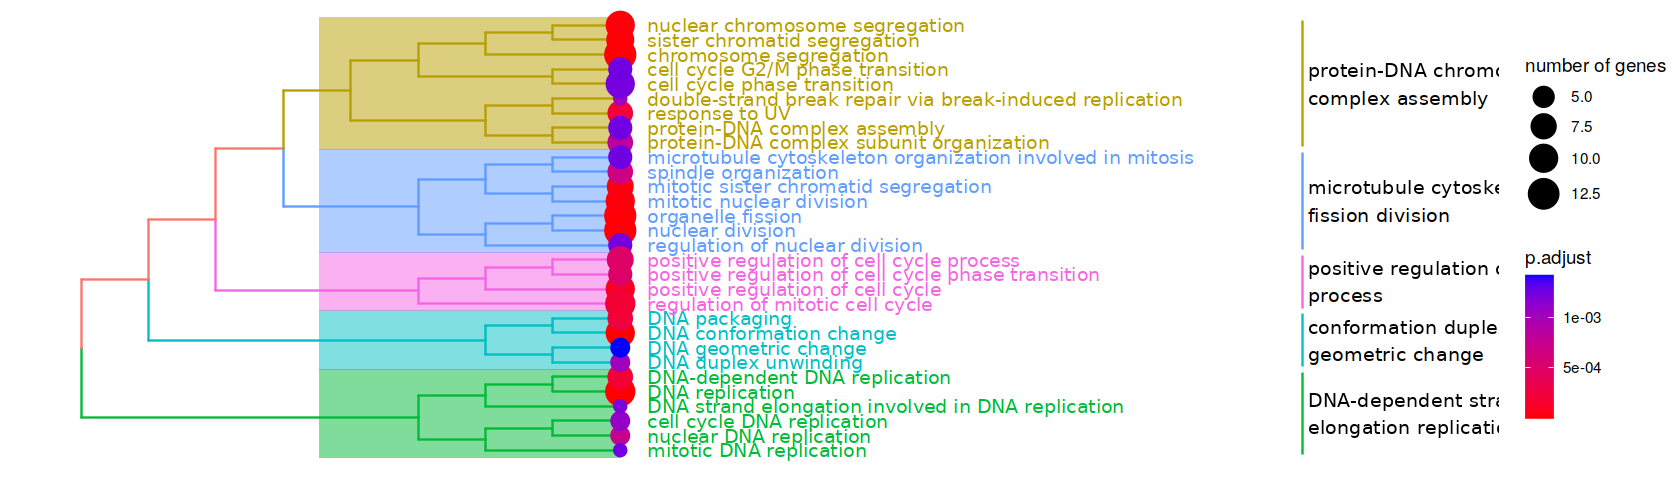

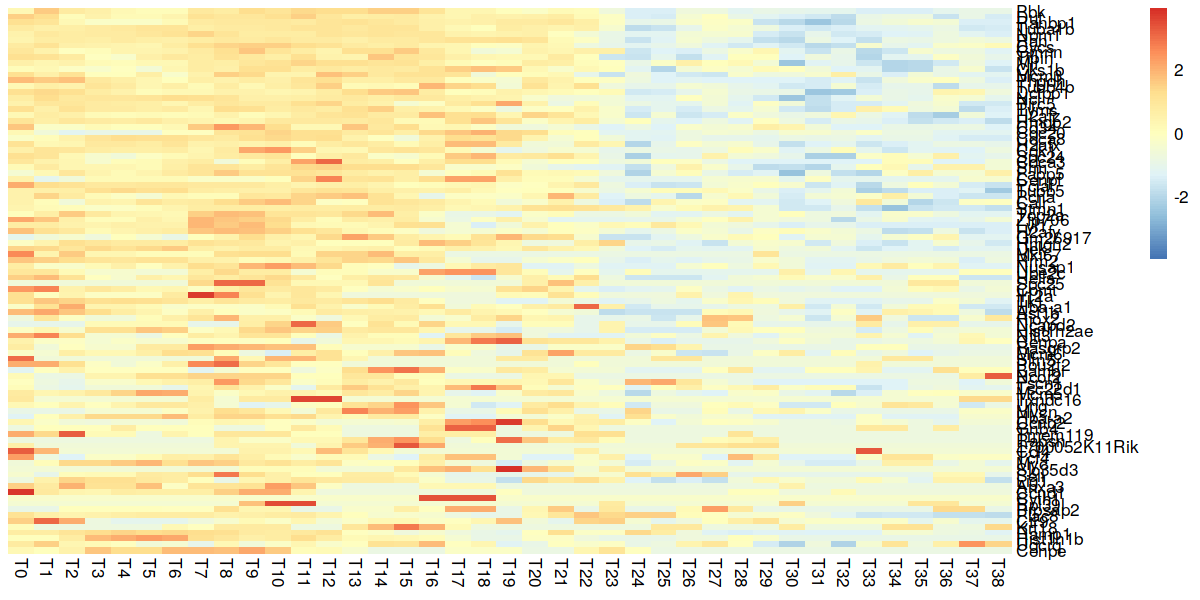

In [16]:
print('Genes:')
print(cat(c4.gene))

print('TFs:')
print(cat(intersect(c4.gene, tf)))

o(14,4)
plot(c4.enrich.tree)

library(pheatmap)
o(10,5)
pheatmap(mat[c4.gene,], scale = 'row', 
         cluster_rows = F, cluster_cols = F, border_color=NA)

In [20]:
data.frame(c4.enrich.res)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0007059,GO:0007059,chromosome segregation,13/86,337/22853,4.096433e-10,7.848766e-07,6.394748e-07,Ran/Birc5/Cdc20/Cdca8/Spc24/Cenpf/Top2a/Mki67/Nusap1/Ube2c/Spc25/Ncapd2/Cenpe,13
GO:0006260,GO:0006260,DNA replication,11/86,253/22853,2.899161e-09,2.777396e-06,2.262871e-06,Npm1/Gmnn/Tipin/Mcm3/Cdk1/Pclaf/Pcna/Rrm2/Mcm6/Mcm5/Lig1,11
GO:0071103,GO:0071103,DNA conformation change,10/86,203/22853,4.824394e-09,3.081180e-06,2.510378e-06,Npm1/Mcm3/Cdk1/Top2a/Nusap1/Hells/Asf1b/Ncapd2/Mcm6/Mcm5,10
GO:0000280,GO:0000280,nuclear division,13/86,440/22853,1.018550e-08,4.878854e-06,3.975025e-06,Ranbp1/Ran/Birc5/Cdc20/Cdca8/Calr/Top2a/Mki67/Nusap1/Ube2c/Ncapd2/Ccnb2/Cenpe,13
GO:0000819,GO:0000819,sister chromatid segregation,9/86,187/22853,3.626213e-08,1.240551e-05,1.010734e-05,Ran/Birc5/Cdc20/Cdca8/Top2a/Nusap1/Ube2c/Ncapd2/Cenpe,9
GO:0048285,GO:0048285,organelle fission,13/86,493/22853,3.884816e-08,1.240551e-05,1.010734e-05,Ranbp1/Ran/Birc5/Cdc20/Cdca8/Calr/Top2a/Mki67/Nusap1/Ube2c/Ncapd2/Ccnb2/Cenpe,13
GO:0098813,GO:0098813,nuclear chromosome segregation,10/86,272/22853,7.730949e-08,2.116071e-05,1.724060e-05,Ran/Birc5/Cdc20/Cdca8/Cenpf/Top2a/Nusap1/Ube2c/Ncapd2/Cenpe,10
GO:0140014,GO:0140014,mitotic nuclear division,10/86,277/22853,9.163654e-08,2.194695e-05,1.788118e-05,Ranbp1/Ran/Birc5/Cdc20/Cdca8/Mki67/Nusap1/Ube2c/Ncapd2/Cenpe,10
GO:0000070,GO:0000070,mitotic sister chromatid segregation,8/86,158/22853,1.468218e-07,3.125674e-05,2.546629e-05,Ran/Birc5/Cdc20/Cdca8/Nusap1/Ube2c/Ncapd2/Cenpe,8


## G1 (Peak T=25)

[1] "Genes:"
Lck H2afv Crip1 Sox4 Tuba8 Perp Lgals9 Vgll4 Ly6d Bcl11b Gse1 Gm49169 Gata1 Pnck Acadm Map4k4 Serpine2 Klf7 Gstm5 Hmgb3 Tmem121 Kdm5c Anxa2 Gadd45a Ifi27 Zfp329 Fbxw4 Dhx34 Cd72 Foxn3 Ahcyl2 Satb1 Sesn1 Armc3 Fyb Mindy2 Bcor Tcf7 Cd63 Hilpda Lat Tmc6 Eva1b Zmynd8 Epsti1 Gm19412 Tk2 Ly6e Cdkn1a Mfsd10 2610035D17Rik Chn2 Cdkn1c Casp6 Klf1 Hbb-bt Kdsr Ube2h Mical1 3830403N18Rik Pycr2 Cela1 Yipf2 Bst2 Xlr4a Grb2 Cpa3 Gfod1 Itga4 H2-T23 Lztfl1 Pik3ip1 Colq Aldh2 Phip Gfi1b Bbc3 Akr1c13 Lat2 Ccnd3 Trbc2 9130015A21Rik Rtp4 Cytip Adgrg1 Bex2 Mgst3 Arntl Fgfbp3 Cdk5 Gyg Rgs2 Psg17 Alox5 Sla2 Emid1 Trim12c Klf6 Eng Drosha Rhoh Grifin Chd2 Dtx3 Tcrg-C2 Crebbp Rec8 Skp1a Fbxo6 Isg15 Trdc Gbp8 Tpm1 Mtss1 Prelid2 Marcksl1 Abtb1 Oscp1 Kif3a Rab37 Smim5 P2ry14 Lpar6 Btg1 Marcks Calm2 Alox5ap Stard10 2810474O19Rik Ogt Rbpms Cln3 Slc39a1 Gstt2 Plekha2 Cttn Rab22a Abcb9 Mta3 Wdr27 Ypel5 Fam189b Hist1h2bc Pdcd4 Izumo4 Narf E230032D23Rik Ldhb Trbc1 Cdc42ep3 Wdcp Kctd10NULL
[1] "TFs:"
Sox4 Bcl1

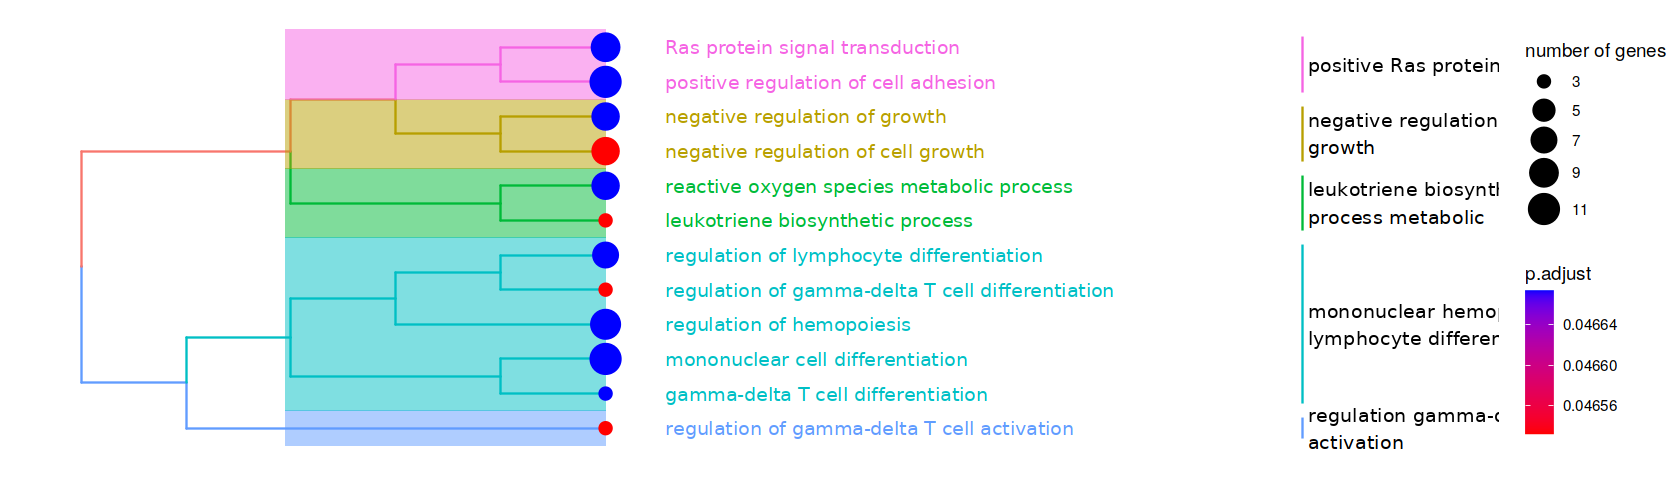

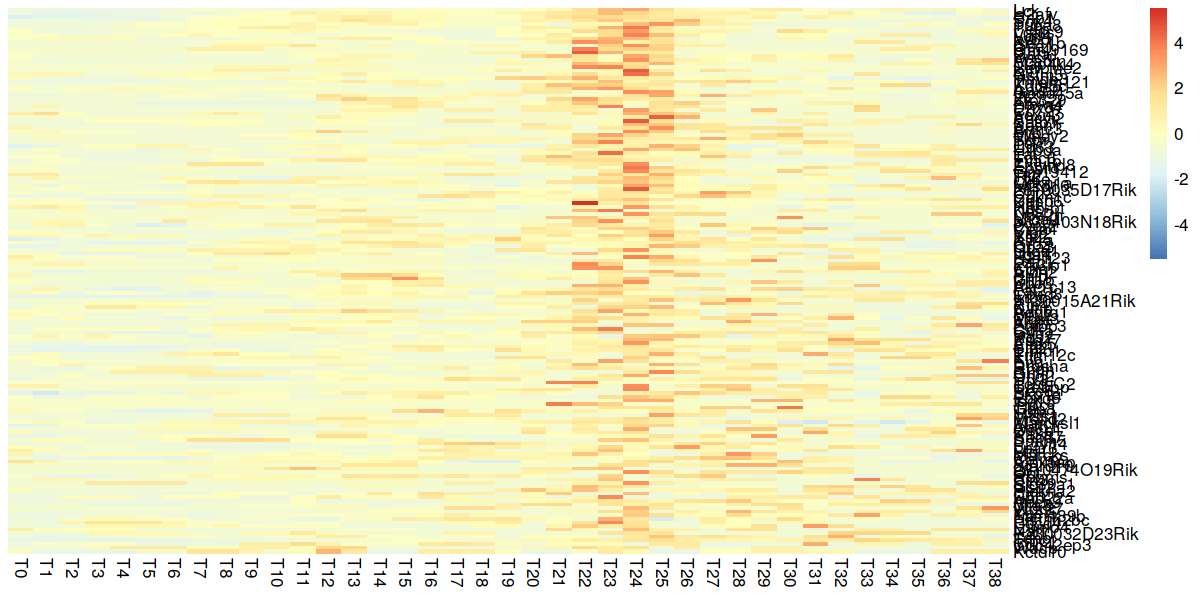

In [12]:
print('Genes:')
print(cat(c1.gene))

print('TFs:')
print(cat(intersect(c1.gene, tf)))

o(14,4)
plot(c1.enrich.tree)

library(pheatmap)
o(10,5)
pheatmap(mat[c1.gene,], scale = 'row', 
         cluster_rows = F, cluster_cols = F, border_color=NA)



In [22]:
as.data.frame(c1.enrich.res)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0030308,GO:0030308,negative regulation of cell growth,8/139,202/22853,3.396183e-05,0.04653187,0.03966270,Vgll4/Serpine2/Sesn1/Cdkn1a/Bst2/Bbc3/Cdk5/Rgs2,8
GO:0019370,GO:0019370,leukotriene biosynthetic process,3/139,12/22853,4.653676e-05,0.04653187,0.03966270,Mgst3/Alox5/Alox5ap,3
GO:0045586,GO:0045586,regulation of gamma-delta T cell differentiation,3/139,14/22853,7.631304e-05,0.04653187,0.03966270,Lck/Sox4/Tcf7,3
GO:0046643,GO:0046643,regulation of gamma-delta T cell activation,3/139,14/22853,7.631304e-05,0.04653187,0.03966270,Lck/Sox4/Tcf7,3
GO:0072593,GO:0072593,reactive oxygen species metabolic process,8/139,243/22853,1.238953e-04,0.04667398,0.03978383,Gadd45a/Sesn1/Cdkn1a/Hbb-bt/Grb2/Aldh2/Alox5/Ogt,8
GO:0045785,GO:0045785,positive regulation of cell adhesion,11/139,471/22853,1.485293e-04,0.04667398,0.03978383,Lck/Sox4/Lgals9/Map4k4/Cd63/Itga4/Adgrg1/Alox5/Rhoh/Tpm1/Plekha2,11
GO:1903706,GO:1903706,regulation of hemopoiesis,10/139,396/22853,1.598122e-04,0.04667398,0.03978383,Lck/Sox4/Lgals9/Gata1/Hmgb3/Tcf7/Gfi1b/Drosha/Rhoh/Isg15,10
GO:0042492,GO:0042492,gamma-delta T cell differentiation,3/139,18/22853,1.680511e-04,0.04667398,0.03978383,Lck/Sox4/Tcf7,3
GO:0007265,GO:0007265,Ras protein signal transduction,9/139,330/22853,1.939803e-04,0.04667398,0.03978383,Map4k4/Lat/Grb2/Adgrg1/Rhoh/Lpar6/Ogt/Cdc42ep3/Kctd10,9


In [ ]:
GO:0045619	GO:0045619	regulation of lymphocyte differentiation	7/139	198/22853	2.144680e-04	0.04667398	0.03978383	Lck/Sox4/Lgals9/Hmgb3/Tcf7/Drosha/Rhoh	7
GO:1903706	GO:1903706	regulation of hemopoiesis	10/139	396/22853	1.598122e-04	0.04667398	0.03978383	Lck/Sox4/Lgals9/Gata1/Hmgb3/Tcf7/Gfi1b/Drosha/Rhoh/Isg15	10


## G3 (Peak T=30)

[1] "Genes:"
Il1r2 Gm4208 Dok3 Cd3d Gsn Ampd1 Ifitm1 Rsu1 Vmac Tmsb15b1 Utrn AC147041.1 Cd2 Irf7 Cyp11a1 Tmem51 1810011H11Rik Hebp2 Ppp1r18 Maged2 Tnrc6b Fxyd7 Fhl2 Vasp Pold4 Gramd1a Agpat4 Tubb2a Serpinb6a Gm31887 Gpr34 Dennd1c Tnfsf11 Bcl3 Tor4a Slfn2 N4bp2l1 Cd9 Cd96 Arhgap9 Helz Plekho1 Gng2 1810041H14Rik Smpdl3a Crtac1 Pink1 Mpped2 Ddc Ms4a4b Dstn Ifitm2 Ckm Stat4 Batf3 Polm Dusp1 Necab2 Ptk2b Ikzf2 Ak8 Gpr65 Plpp6 I830077J02Rik Gdi1 Ccr9 Capn3 Pigl Tox Lrrc52 Ccr2 Car7 Rcn3 Lbh Aplp2 Fgr Pld3 Fcgr3 Cldnd1 Napsa Aak1 Rgs1 Pdcd1 Tmem50b Hpcal1 Prr5l Nudt18 6330403K07Rik R3hdm2 Tspan32 Pacsin1 Sp100 Gm30054 Ms4a6b Pea15a Dlgap4 Gm9856 1600014C10Rik Rom1 AB124611 Pdlim2 Ifngr2 Abhd5 Btg2 Cd3g Asb2 Pitpnc1 H2-Oa 5033430I15Rik Tmem141 Tpm2 Jund Gatsl3 Ptms Il12rb1 Vim Lgals1 Pgam2 Rgs10 Atp1b1 Lsp1 Tnp2 Gpr171 Fgl2 Pcmtd2 Itgb7 Zmym5 Runx3 Nfkb1 H19 Rgs14 Tmem9b Hes1 Glipr2 Sp7 Aff4 Blvrb Arid5a Nrgn Cd79b Cfp Eya2 Rasa3 Tubb2b N4bp3 Fam129a Rnase6 Sat1 Lcp2 Relb Fnbp1 Jun Gem Mllt3 S

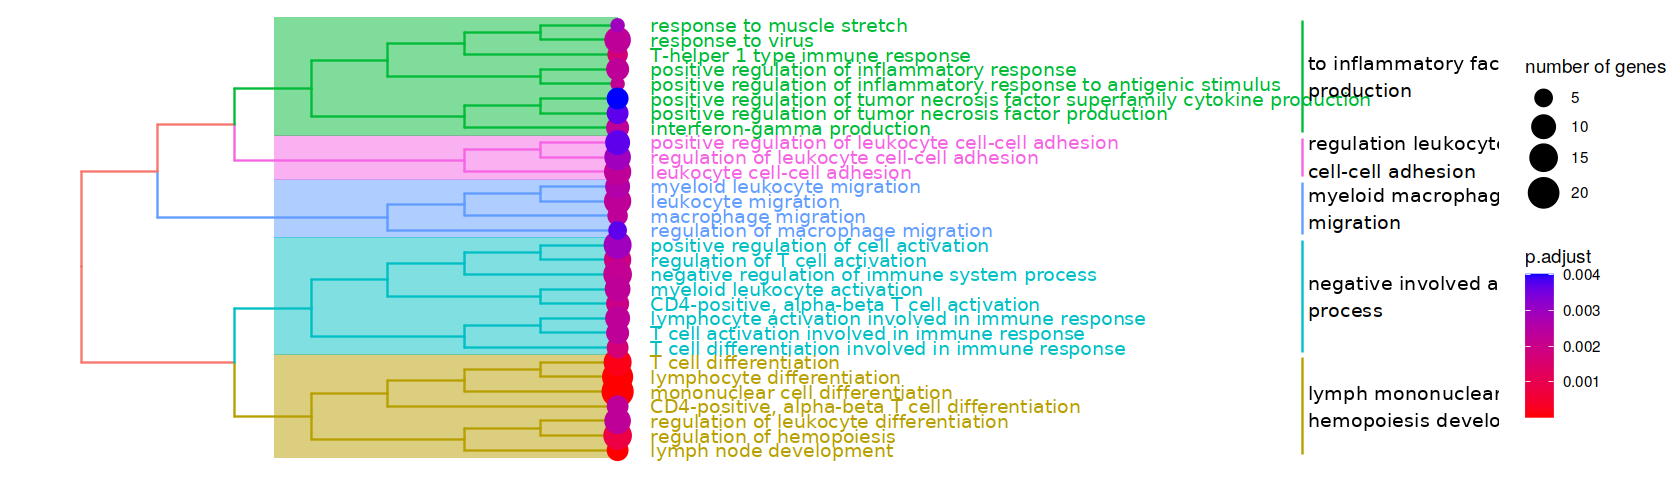

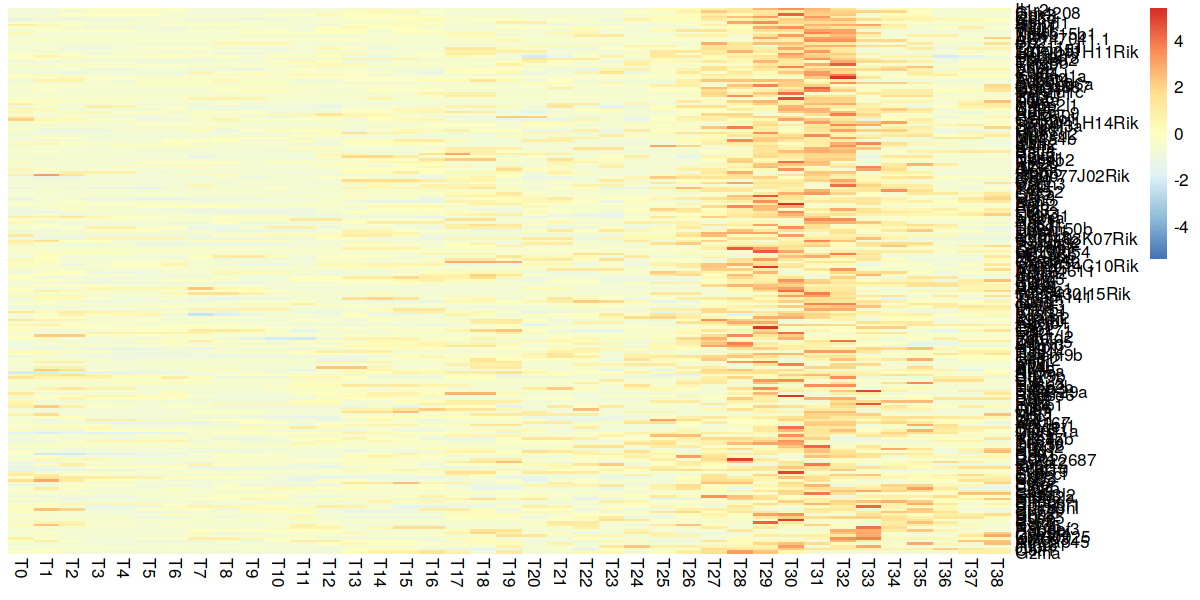

In [14]:
print('Genes:')
print(cat(c3.gene))

print('TFs:')
print(cat(intersect(c3.gene, tf)))

o(14,4)
plot(c3.enrich.tree)

library(pheatmap)
o(10,5)
pheatmap(mat[c3.gene,], scale = 'row', 
         cluster_rows = F, cluster_cols = F, border_color=NA)

In [15]:
as.data.frame(c3.enrich.res)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:1903131,GO:1903131,mononuclear cell differentiation,21/192,486/22853,9.678355e-10,2.716714e-06,2.311599e-06,Cd3d/Bcl3/Batf3/Polm/Ptk2b/Ccr9/Tox/Ccr2/Cd3g/H2-Oa/Lgals1/Fgl2/Runx3/Cd79b/Relb/Jun/Id2/Fcer1g/Lag3/Rorc/Ccr7,21
GO:0048535,GO:0048535,lymph node development,7/192,31/22853,5.870753e-09,5.595180e-06,4.760829e-06,Tnfsf11/Tox/Nfkb1/Id2/Cxcr5/Rorc/Ccr7,7
GO:0030098,GO:0030098,lymphocyte differentiation,19/192,438/22853,5.979886e-09,5.595180e-06,4.760829e-06,Cd3d/Bcl3/Polm/Ptk2b/Ccr9/Tox/Ccr2/Cd3g/H2-Oa/Lgals1/Fgl2/Runx3/Cd79b/Relb/Id2/Fcer1g/Lag3/Rorc/Ccr7,19
GO:0030217,GO:0030217,T cell differentiation,14/192,297/22853,2.382334e-07,1.671803e-04,1.422504e-04,Cd3d/Bcl3/Ccr9/Tox/Ccr2/Cd3g/H2-Oa/Fgl2/Runx3/Relb/Fcer1g/Lag3/Rorc/Ccr7,14
GO:1903706,GO:1903706,regulation of hemopoiesis,15/192,396/22853,1.403787e-06,7.880859e-04,6.705667e-04,Tnfsf11/Ptk2b/Tox/Ccr2/H2-Oa/Gpr171/Fgl2/Runx3/Jun/Id2/Ets1/Fos/Lag3/Rorc/Ccr7,15
GO:0042088,GO:0042088,T-helper 1 type immune response,6/192,50/22853,3.800387e-06,1.695368e-03,1.442555e-03,Bcl3/Ccr2/Il12rb1/Arid5a/Relb/Ccr7,6
GO:0002292,GO:0002292,T cell differentiation involved in immune response,7/192,78/22853,4.227851e-06,1.695368e-03,1.442555e-03,Bcl3/Ccr2/Fgl2/Relb/Fcer1g/Rorc/Ccr7,7
GO:0050863,GO:0050863,regulation of T cell activation,13/192,338/22853,6.126130e-06,1.959695e-03,1.667466e-03,Tnfsf11/Tox/Ccr2/H2-Oa/Il12rb1/Lgals1/Fgl2/Runx3/Hes1/Cd81/Lag3/Rorc/Ccr7,13
GO:0035710,GO:0035710,"CD4-positive, alpha-beta T cell activation",8/192,116/22853,6.283312e-06,1.959695e-03,1.667466e-03,Bcl3/Tox/Ccr2/Runx3/Relb/Cd81/Rorc/Ccr7,8


In [ ]:


GO:0050863	GO:0050863	regulation of T cell activation	13/192	338/22853	6.126130e-06	1.959695e-03	1.667466e-03	Tnfsf11/Tox/Ccr2/H2-Oa/Il12rb1/Lgals1/Fgl2/Runx3/Hes1/Cd81/Lag3/Rorc/Ccr7	13

## G2 (Peak T=35)

[1] "Genes:"
Ltb Gimap4 Thy1 Serpina3g Hmgn3 Rara Mdk Arg1 Tnfrsf25 Dlk1 Cdyl2 Map3k8 Card11 Lmo4 Klrd1 Il2rb Tcrg-C4 Pglyrp1 Zfp36l1 Nipal1 Parp16 Lta Egr1 Anxa6 Tbx21 Tgtp2 Txk Socs1 Gm15417 Pim2 Nfkbia Dock10 S100a4 Ifngr1 Hcst Ecm1 Trpv2 Fsd1 Ctsf Tox2 Sla Erich1 Car2 Maf Atp2b1 S100a1 Tcp11l2 Ctss Batf Itm2c Smco4 Fndc3a Stoml1 Cxcr3 Itgb2 Slc6a13 Hormad2 Pde6d Zbp1 Aqp9 Paqr7 Gimap6 1700113H08Rik Nfkbid Psap Arhgap25 Agpat3 Nmb H2-K1 Chad Shisa5 Gata3 Cxcr6 Gm15738 Inpp1 Jak1 Dhrs3 Jarid2 Ier2 Dok1 Col9a3 Cd200r4 Dbn1 Rab19 Il7r Ctsw Soat2 C1qtnf6 Il17f H2-D1 Klf2 Morc1 Skap1 Nfkb2 Cd28 Wdr62 Man2a1 Cdan1 Selplg Cox7a1 Cited4 Sp4 Eno1 Clnk Cd52 Gpr18 Selenop Slc9a9 Gimap5 F8a Serinc2 Adgre5 Ckb 1110008P14Rik Ccdc80 Stat1 Capg Lgals3 Icos Ugcg Cd74 Tpm4 Grap H2-Ab1 Gm14029 Tmem9 Tnfrsf9 Lmna Wdr86 St3gal6 Tpst2 Lonp2 Fgf15 Xlr4b 2810001G20Rik Plekhf1 Scpep1 Itm2b Plin3 Rnf166 Zbtb7b Rora Tapbpl Hist1h2ac Pkp3 Ppp3ca Lgmn Rundc1 Pnisr Cd160 AW112010 Ighm Cd7 4930523C07Rik Tcrg-C1 P

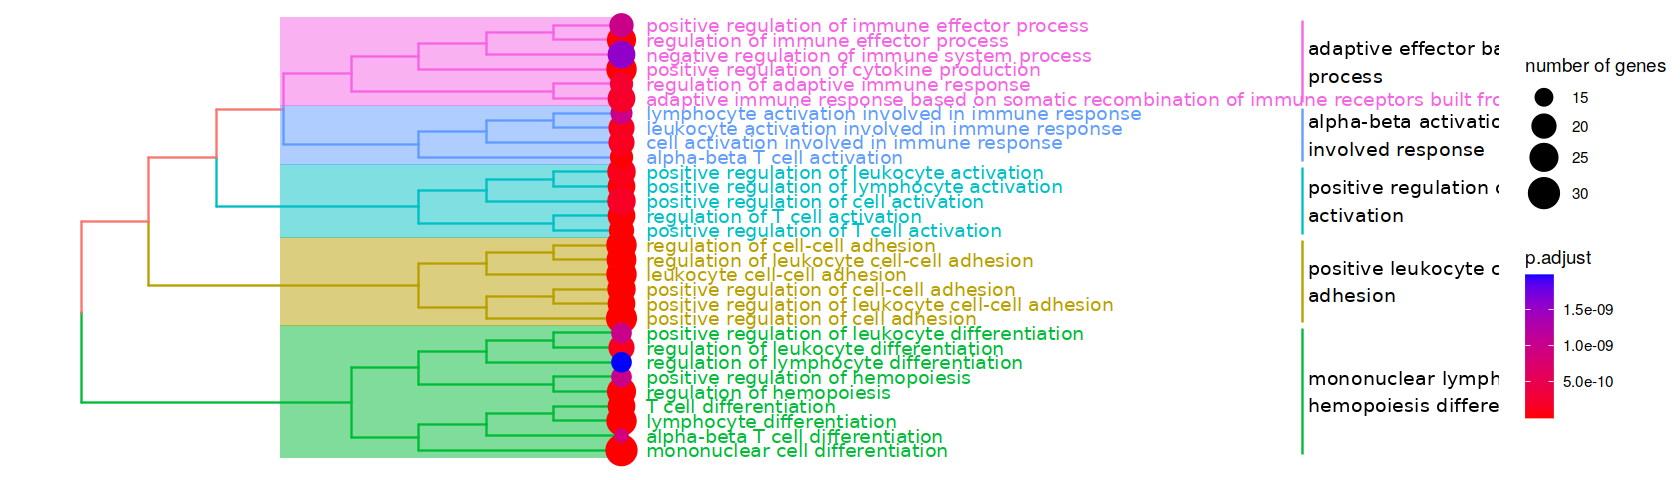

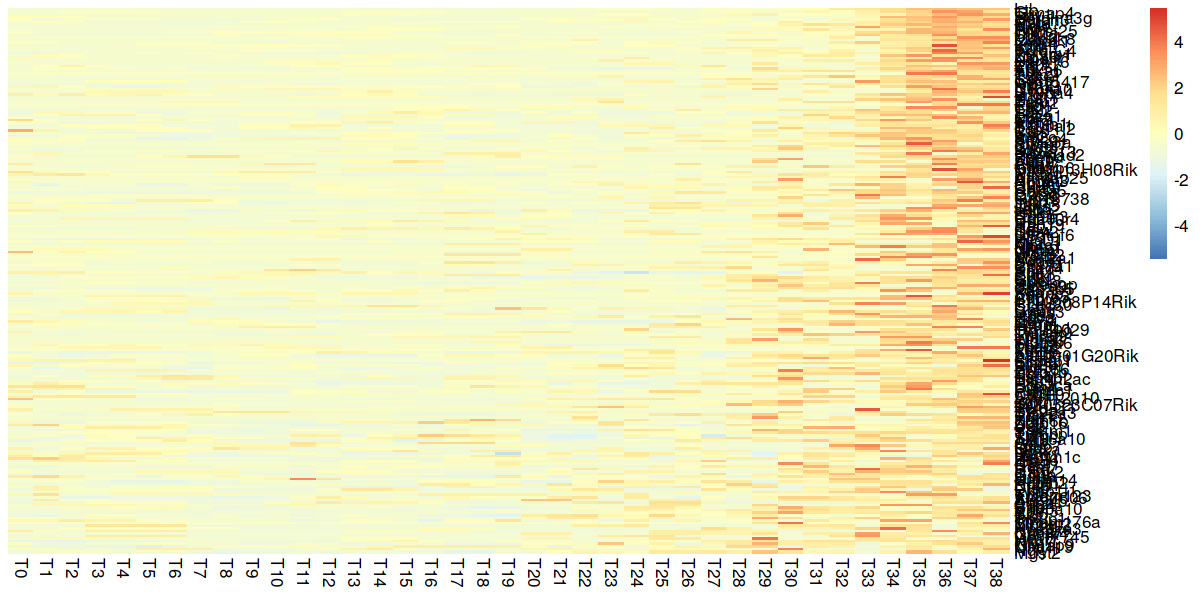

In [13]:
print('Genes:')
print(cat(c2.gene))

print('TFs:')
print(cat(intersect(c2.gene, tf)))

o(14,4)
plot(c2.enrich.tree)

library(pheatmap)
o(10,5)
pheatmap(mat[c2.gene,], scale = 'row', 
         cluster_rows = F, cluster_cols = F, border_color=NA)

In [21]:
as.data.frame(c2.enrich.res)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:1903039,GO:1903039,positive regulation of leukocyte cell-cell adhesion,23/198,240/22853,1.437797e-17,2.311712e-14,1.793400e-14,Thy1/Rara/Mdk/Card11/Socs1/Itgb2/Nfkbid/Gata3/Il7r/Skap1/Cd28/Gimap5/Icos/Cd74/H2-Ab1/Zbtb7b/Cd160/Zbtb16/Vsir/Itgal/B2m/Icam1/Ccl5,23
GO:1903037,GO:1903037,regulation of leukocyte cell-cell adhesion,26/198,333/22853,1.616199e-17,2.311712e-14,1.793400e-14,Thy1/Rara/Mdk/Arg1/Card11/Tbx21/Socs1/Itgb2/Nfkbid/Gata3/Il7r/Skap1/Cd28/Gimap5/Lgals3/Icos/Cd74/H2-Ab1/Zbtb7b/Cd160/Zbtb16/Vsir/Itgal/B2m/Icam1/Ccl5,26
GO:0007159,GO:0007159,leukocyte cell-cell adhesion,27/198,372/22853,2.364992e-17,2.311712e-14,1.793400e-14,Thy1/Rara/Mdk/Arg1/Card11/Tbx21/Socs1/Itgb2/Nfkbid/Gata3/Il7r/Skap1/Cd28/Selplg/Gimap5/Lgals3/Icos/Cd74/H2-Ab1/Zbtb7b/Cd160/Zbtb16/Vsir/Itgal/B2m/Icam1/Ccl5,27
GO:1903131,GO:1903131,mononuclear cell differentiation,30/198,486/22853,3.062885e-17,2.311712e-14,1.793400e-14,Rara/Mdk/Card11/Pglyrp1/Zfp36l1/Egr1/Tbx21/Txk/Socs1/Dock10/Batf/Nfkbid/Psap/Gata3/Il7r/Cd28/Gpr18/Gimap5/Cd74/H2-Ab1/Zbtb7b/Rora/Ighm/Zbtb16/Vsir/B2m/Csf2/Ly9/Tmem176a/Camk4,30
GO:0022409,GO:0022409,positive regulation of cell-cell adhesion,24/198,288/22853,6.904110e-17,4.168702e-14,3.234031e-14,Thy1/Rara/Mdk/Card11/Socs1/Itgb2/Nfkbid/Gata3/Jak1/Il7r/Skap1/Cd28/Gimap5/Icos/Cd74/H2-Ab1/Zbtb7b/Cd160/Zbtb16/Vsir/Itgal/B2m/Icam1/Ccl5,24
GO:0045785,GO:0045785,positive regulation of cell adhesion,28/198,471/22853,9.980253e-16,5.021731e-13,3.895800e-13,Thy1/Rara/Mdk/Card11/Socs1/Itgb2/Nfkbid/Gata3/Jak1/Dbn1/Il7r/Skap1/Cd28/Gimap5/Ccdc80/Icos/Cd74/H2-Ab1/Zbtb7b/Ppp3ca/Cd160/Zbtb16/Vsir/Itgal/B2m/Icam1/S100a10/Ccl5,28
GO:0030098,GO:0030098,lymphocyte differentiation,27/198,438/22853,1.390644e-15,5.920953e-13,4.593407e-13,Rara/Mdk/Card11/Pglyrp1/Zfp36l1/Egr1/Tbx21/Txk/Socs1/Dock10/Batf/Nfkbid/Psap/Gata3/Il7r/Cd28/Gpr18/Gimap5/Cd74/H2-Ab1/Zbtb7b/Rora/Ighm/Zbtb16/Vsir/B2m/Ly9,27
GO:0030217,GO:0030217,T cell differentiation,23/198,297/22853,1.568984e-15,5.920953e-13,4.593407e-13,Rara/Mdk/Card11/Zfp36l1/Egr1/Tbx21/Txk/Socs1/Batf/Nfkbid/Psap/Gata3/Il7r/Cd28/Gpr18/Gimap5/Cd74/Zbtb7b/Rora/Zbtb16/Vsir/B2m/Ly9,23
GO:0022407,GO:0022407,regulation of cell-cell adhesion,27/198,457/22853,3.940789e-15,1.201771e-12,9.323197e-13,Thy1/Rara/Mdk/Arg1/Card11/Tbx21/Socs1/Itgb2/Nfkbid/Gata3/Jak1/Il7r/Skap1/Cd28/Gimap5/Lgals3/Icos/Cd74/H2-Ab1/Zbtb7b/Cd160/Zbtb16/Vsir/Itgal/B2m/Icam1/Ccl5,27


In [ ]:
GO:1903039	GO:1903039	positive regulation of leukocyte cell-cell adhesion	23/198	240/22853	1.437797e-17	2.311712e-14	1.793400e-14	Thy1/Rara/Mdk/Card11/Socs1/Itgb2/Nfkbid/Gata3/Il7r/Skap1/Cd28/Gimap5/Icos/Cd74/H2-Ab1/Zbtb7b/Cd160/Zbtb16/Vsir/Itgal/B2m/Icam1/Ccl5	23


# Summary

In [25]:
path.gene.modules <- list(
    "G5"= list(gene=c5.gene, enrichment=as.data.frame(c5.enrich.res), peakT=3),
    "G4"= list(gene=c4.gene, enrichment=as.data.frame(c4.enrich.res), peakT=7),
    "G1"= list(gene=c1.gene, enrichment=as.data.frame(c1.enrich.res), peakT=25),
    "G3"= list(gene=c3.gene, enrichment=as.data.frame(c3.enrich.res), peakT=30),
    "G2"= list(gene=c2.gene, enrichment=as.data.frame(c2.enrich.res), peakT=35)
)
names(path.gene.modules)

[1] "G5" "G4" "G1" "G3" "G2"

In [88]:
saveRDS(path.gene.modules, file = '221122-FL.Mfuzz.gene.modules.rds')

In [27]:
terms.oi<-rbind(
    read.csv('./GOsel_differentiation.tsv', sep='\t', header = F),
    read.csv('./GOsel_activation.tsv', sep='\t', header = F),
    read.csv('./GOsel_others.tsv', sep='\t', header = F)
)
colnames(terms.oi)<-c('go','type','name')
terms.oi

go,type,name
<chr>,<chr>,<chr>
GO:0043367,biological_process,"CD4-positive, alpha-beta T cell differentiation"
GO:0002292,biological_process,T cell differentiation involved in immune response
GO:1902105,biological_process,regulation of leukocyte differentiation
GO:0045582,biological_process,positive regulation of T cell differentiation
GO:0042093,biological_process,T-helper cell differentiation
GO:0030217,biological_process,T cell differentiation
GO:0045619,biological_process,regulation of lymphocyte differentiation
GO:0046632,biological_process,alpha-beta T cell differentiation
GO:1903706,biological_process,regulation of hemopoiesis


In [50]:
goi.fl <- c(
    path.gene.modules[['G5']]$enrichment %>% filter(ID %in% terms.oi$go) %>%
    pull(geneID) %>% strsplit('/') %>% unlist %>% unique,

    path.gene.modules[['G4']]$enrichment %>% filter(ID %in% terms.oi$go) %>%
    pull(geneID) %>% strsplit('/') %>% unlist %>% unique,

    path.gene.modules[['G1']]$enrichment %>% filter(ID %in% terms.oi$go) %>%
    pull(geneID) %>% strsplit('/') %>% unlist %>% unique,

    path.gene.modules[['G3']]$enrichment %>% filter(ID %in% terms.oi$go) %>%
    pull(geneID) %>% strsplit('/') %>% unlist %>% unique,

    path.gene.modules[['G2']]$enrichment %>% filter(ID %in% terms.oi$go) %>%
    pull(geneID) %>% strsplit('/') %>% unlist %>% unique
)


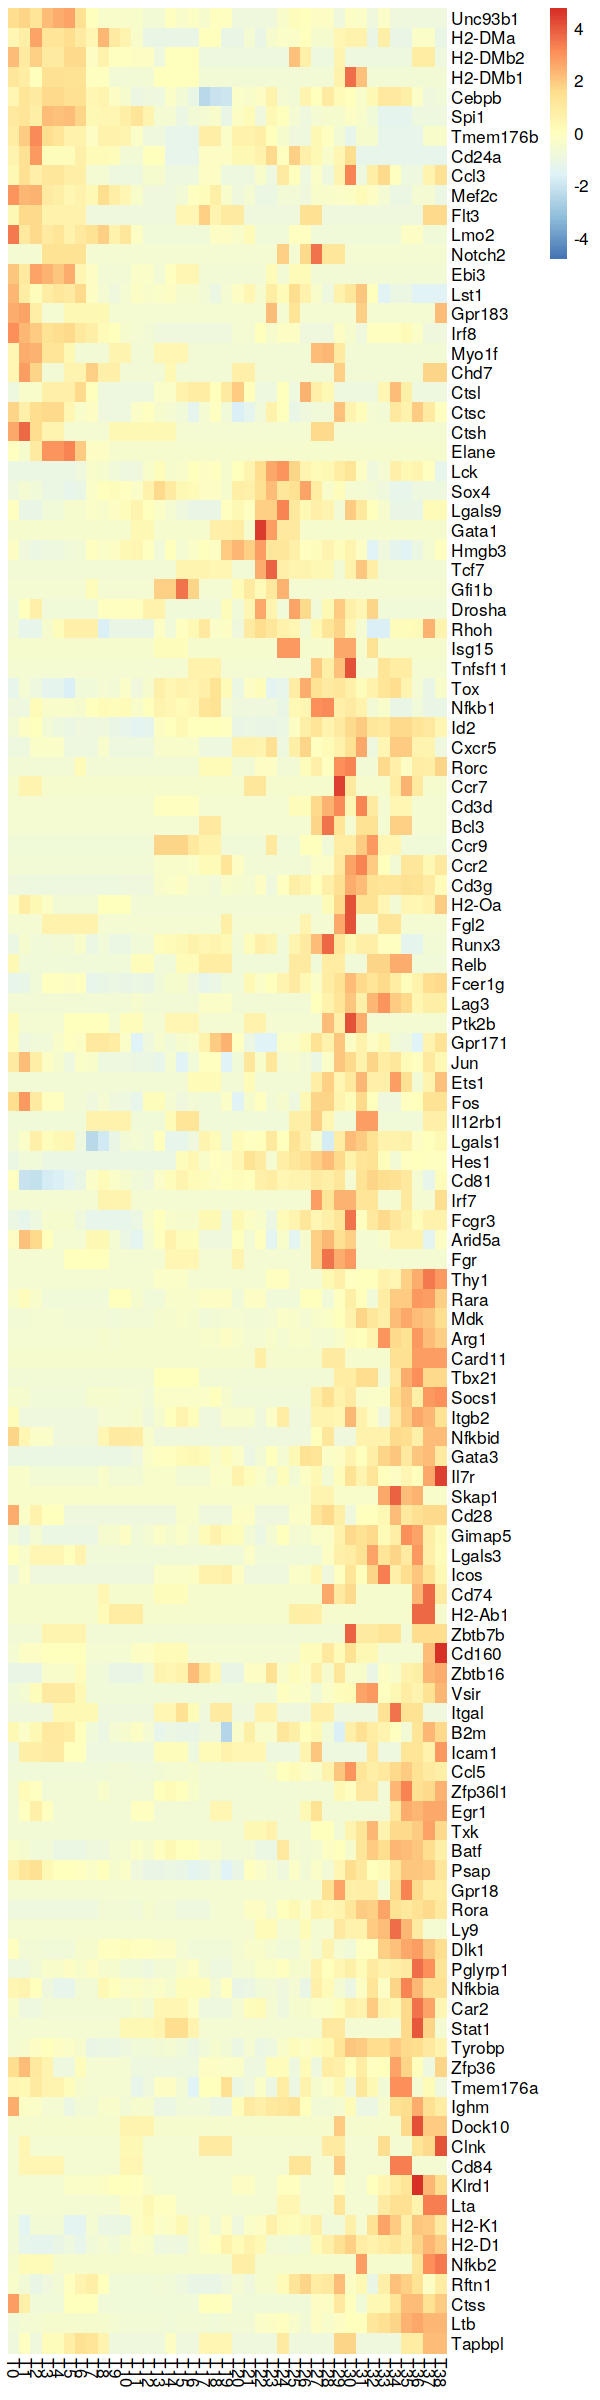

In [51]:
library(pheatmap)
o(5,20)
pheatmap(mat[goi.fl,], scale = 'row', 
         cluster_rows = F, cluster_cols = F, border_color=NA)

In [52]:
saveRDS(goi.fl, file='221122-FL.GOselected.genes.rds')

In [99]:
goi.abm = readRDS('221122-ABM.GOselected.genes.rds')
goi.fl = readRDS('221122-FL.GOselected.genes.rds')
goi.common= intersect(goi.fl, goi.abm)
goi.abm.specific = setdiff(goi.abm, goi.fl)
goi.fl.specific  = setdiff(goi.fl, goi.abm)

In [100]:
cat(goi.common)

H2-DMb2 H2-DMb1 Cebpb Spi1 Tmem176b Cd24a Ccl3 Mef2c Flt3 Lmo2 Notch2 Ebi3 Gpr183 Irf8 Myo1f Ctsl Ctsc Ctsh Elane Lck Sox4 Lgals9 Tcf7 Gfi1b Drosha Rhoh Isg15 Tox Id2 Cxcr5 Rorc Ccr2 Cd3g H2-Oa Fgl2 Runx3 Relb Fcer1g Lag3 Gpr171 Jun Ets1 Fos Lgals1 Hes1 Fcgr3 Arid5a Thy1 Rara Mdk Arg1 Card11 Socs1 Itgb2 Nfkbid Gata3 Il7r Skap1 Cd28 Gimap5 Icos Cd74 H2-Ab1 Zbtb7b Cd160 Zbtb16 Vsir Itgal B2m Ccl5 Zfp36l1 Txk Batf Gpr18 Rora Pglyrp1 Stat1 Tyrobp Zfp36 Tmem176a Ighm Dock10 Clnk Klrd1 Lta H2-K1 H2-D1 Rftn1 Ctss Ltb Tapbpl

In [101]:
goi.fl.specific

[1] "Unc93b1" "H2-DMa"  "Lst1"    "Chd7"    "Gata1"   "Hmgb3"   "Tnfsf11"
 [8] "Nfkb1"   "Ccr7"    "Cd3d"    "Bcl3"    "Ccr9"    "Ptk2b"   "Il12rb1"
[15] "Cd81"    "Irf7"    "Fgr"     "Tbx21"   "Lgals3"  "Icam1"   "Egr1"   
[22] "Psap"    "Ly9"     "Dlk1"    "Nfkbia"  "Car2"    "Cd84"    "Nfkb2"

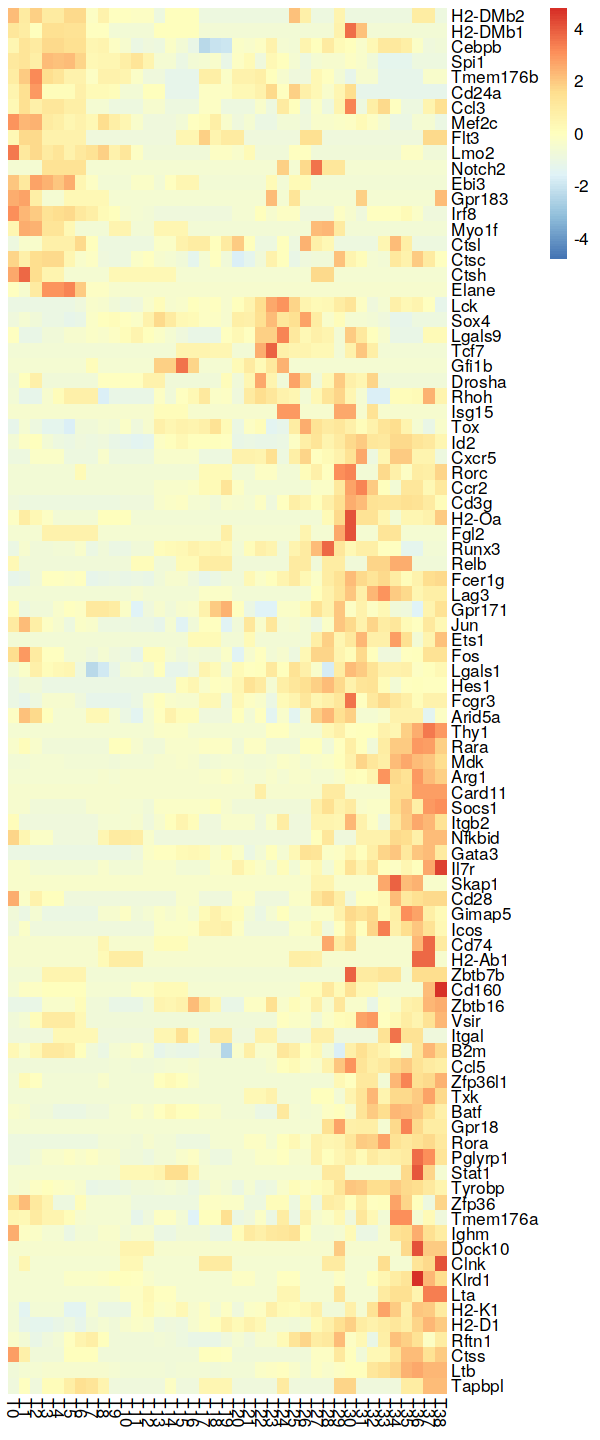

In [78]:
library(pheatmap)
o(5,12)
pheatmap(mat[goi.common,], scale = 'row', 
         cluster_rows=F, cluster_cols = F, border_color=NA)

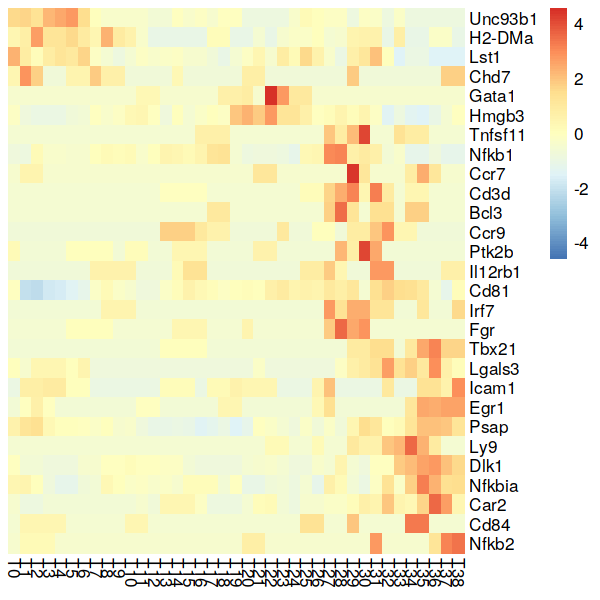

In [64]:
library(pheatmap)
o(5,5)
pheatmap(mat[goi.fl.specific,], scale='row',
         cluster_rows = F, cluster_cols = F, border_color=NA)

# GSVA

## GOBP analysis

In [82]:
# get expressions
expr = read.csv('./221112-FL-ILCprimed-PathExpr.csv', row.names = 1)
colnames(expr) <- paste("T",0:(ncol(mat)-1), sep='')


In [83]:
# get gene sets
library(msigdbr)
library(dplyr)
m_gene_sets = msigdbr(species = "mouse", category = "C5", subcategory = 'BP')

df <- m_gene_sets %>% dplyr::select(gene_symbol,gs_exact_source) %>% 
        filter(gs_exact_source %in% terms.oi$go) %>% 
        filter(gene_symbol %in% rownames(expr))%>%
        group_by(gs_exact_source) %>%
        summarise(genes = paste(gene_symbol, collapse=", "))

term2genes <- strsplit(df$genes, ', ')
names(term2genes)<-df$gs_exact_source

In [84]:
term2genes

$`GO:0002292`
 [1] "Anxa1"   "Batf"    "Bcl3"    "Cd86"    "Clec4d"  "Clec4e"  "Entpd7" 
 [8] "Eomes"   "Fcer1g"  "Fgl2"    "Foxp1"   "Gata3"   "Gpr183"  "H2-Eb1" 
[15] "Hlx"     "Hmgb1"   "Il12rb1" "Il18"    "Il18r1"  "Il2"     "Il4"    
[22] "Il4ra"   "Il6ra"   "Lef1"    "Lgals9"  "Ly9"     "Mtor"    "Myb"    
[29] "Nfkbid"  "Rara"    "Rc3h1"   "Rc3h2"   "Relb"    "Ripk2"   "Rora"   
[36] "Rorc"    "Sema4a"  "Smad7"   "Socs5"   "Stat3"   "Stat6"   "Tbx21"  
[43] "Tmem98"  "Tsc1"    "Zbtb7b"  "Zc3h12a" "Zfpm1"  

$`GO:0002460`
  [1] "Ada"      "Adam17"   "Ahr"      "Aicda"    "Anxa1"    "Arg1"    
  [7] "Arid5a"   "Atad5"    "B2m"      "Bach2"    "Batf"     "Bcl10"   
 [13] "Bcl3"     "Btk"      "C1qb"     "C1qbp"    "Card9"    "Ccr2"    
 [19] "Ccr6"     "Cd1d1"    "Cd27"     "Cd28"     "Cd4"      "Cd74"    
 [25] "Cd81"     "Clcf1"    "Cr1l"     "Cr1l"     "Ctsc"     "Ctsh"    
 [31] "Dennd1b"  "Dusp22"   "Ebi3"     "Entpd7"   "Ercc1"    "Exo1"    
 [37] "Exosc3"   "Fadd"     "Fbxo38"   "Fcer1g"   "Fcgr1"    "Fcgr2b"  
 [43] "Fut7"     "Gapt"     "Gata3"    "Gnl1"     "H2-D1"    "H2-DMa"  
 [49] "H2-DMb1"  "H2-Oa"    "H2-Aa"    "H2-Aa"    "H2-Ab1"   "H2-Ab1"  
 [55] "H2-Eb1"   "H2-Eb1"   "H2-T23"   "H2-M3"    "H2-M3"    "Hlx"     
 [61] "Hmces"    "Hmgb1"    "Hprt"     "Hras"     "Hspd1"    "Icam1"   
 [67] "Ighm"     "Ighv1-23" "Ighv1-77" "Ighv1-82" "Ighv1-23" "Ighv1-77"
 [73] "Ighv1-82" "Ighv1-23" "Ighv1-77" "Ighv1-82" "Ighv1-23" "Ighv1-77"
 [79] "Ighv1-82" "Ighv1-23" "Ighv1-77" "Ighv1-82" "Ighv1-23" "Ighv1-77"
 [85] "Ighv1-82" "Il12a"    "Il12rb1"  "Il17ra"   "Il18"     "Il18r1"  
 [91] "Il1r1"    "Il2"      "Il21r"    "Il4"      "Il4ra"    "Il6ra"   
 [97] "Il7r"     "Il9r"     "Inpp5d"   "Irf7"     "Klhl6"    "Klrd1"   
[103] "Kmt5b"    "Kmt5c"    "Lef1"     "Pirb"     "Lta"      "Ly9"     
[109] "Mad2l2"   "Map3k7"   "Mef2c"    "Mlh1"     "Msh2"     "Msh6"    
[115] "Mtor"     "Myo1g"    "Nbn"      "Nckap1l"  "Ndfip1"   "Nfkb2"   
[121] "Nfkbid"   "Notch1"   "Nsd2"     "Parp3"    "Paxip1"   "Phb"     
[127] "Pkn1"     "Pla2g4a"  "Ppp3cb"   "Prkcd"    "Prkcq"    "Ptpn6"   
[133] "Ptprc"    "Rab27a"   "Rc3h1"    "Rc3h2"    "Relb"     "Rftn1"   
[139] "Rif1"     "Ripk2"    "Ripk3"    "Rnf168"   "Rnf8"     "Rora"    
[145] "Rorc"     "Sash3"    "Sema4a"   "Sla2"     "Slc15a4"  "Smad7"   
[151] "Socs5"    "Stat3"    "Stat6"    "Stx7"     "Supt6"    "Swap70"  
[157] "Tbx21"    "Tcirg1"   "Tfrc"     "Tgfb1"    "Thoc1"    "Tmem98"  
[163] "Tnf"      "Tnfaip3"  "Traf2"    "Traf3ip2" "Traf6"    "Trbc1"   
[169] "Trbc2"    "Trbc1"    "Trbc2"    "Unc13d"   "Ung"      "Was"     
[175] "Zbtb1"    "Zbtb7b"   "Zc3h12a" 

$`GO:0002474`
 [1] "Abcb9"  "B2m"    "Calr"   "Erap1"  "Fcer1g" "H2-D1"  "H2-T23" "H2-M3" 
 [9] "H2-M3"  "Ide"    "Ikbkb"  "Lnpep"  "Pdia3"  "Sar1b"  "Tap1"   "Tap2"  
[17] "Tapbp"  "Tapbpl"

$`GO:0002501`
 [1] "B2m"     "Calr"    "H2-DMa"  "H2-DMb1" "H2-Oa"   "H2-Aa"   "H2-Aa"  
 [8] "H2-Ab1"  "H2-Ab1"  "H2-Eb1"  "H2-Eb1"  "Pdia3"   "Tapbp"   "Tapbpl" 

$`GO:0022408`
 [1] "Abl1"      "Adora2a"   "Akna"      "Akt1"      "Anxa1"     "Arg1"     
 [7] "Ass1"      "Bmp4"      "Casp3"     "Cbfb"      "Cblb"      "Ccl25"    
[13] "Cd300a"    "Cd74"      "Cd86"      "Cd9"       "Cebpb"     "Cr1l"     
[19] "Ctsg"      "Dlg1"      "Dusp22"    "Epcam"     "Fcgr2b"    "Fgl2"     
[25] "Fxyd5"     "Glmn"      "Gtpbp4"    "H2-Eb1"    "H2-M3"     "Hlx"      
[31] "Hmgb1"     "Il2"       "Il4"       "Il4ra"     "Itch"      "Jak2"     
[37] "Lag3"      "Laptm5"    "Lax1"      "Lgals3"    "Lgals9"    "Lgals9"   
[43] "Lgals9"    "Pirb"      "Pirb"      "Mad1l1"    "Mad2l2"    "Map2k5"   
[49] "Mapk7"     "Mdk"       "Mettl3"    "Mia3"      "Nckap1l"   "Ndfip1"   
[55] "Nf2"       "Notch1"    "Nrarp"     "Pag1"      "Peli1"     "Ppm1f"    
[61] "Prdx2"     "Prkar1a"   "Prkcd"     "Ptpn2"     "Ptpn22"    "Ptpn6"    
[67] "Rag2"      "Rc3h1"     "Rc3h2"     "Rdx"       "Rgcc"      "Ripor2"   
[73] "Runx1"     "Runx3"     "Scrib"     "S

In [86]:
library(GSVA)
gsva.result = gsva(as.matrix(expr), gset.idx.list = term2genes)

rownames(terms.oi) <-terms.oi$go
rownames(gsva.result )<- terms.oi[rownames(gsva.result), 'name']

Warning message in .filterFeatures(expr, method):
“191 genes with constant expression values throuhgout the samples.”
Warning message in .filterFeatures(expr, method):
“Since argument method!="ssgsea", genes with constant expression values are discarded.”


Estimating GSVA scores for 16 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



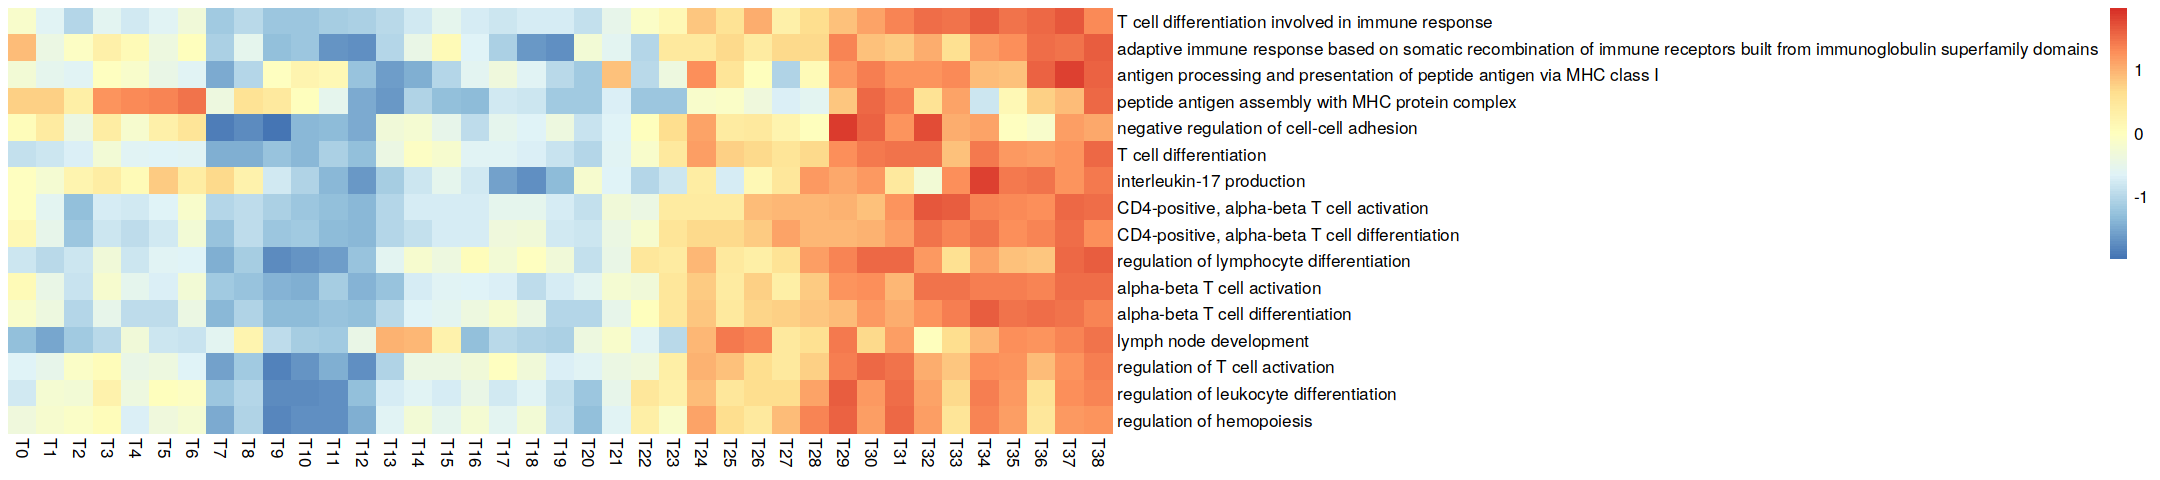

In [87]:
o(18,4)
pheatmap(gsva.result, cluster_rows = F, cluster_cols = F, scale = 'row')

## Gata3-Rorc-Notch axis

In [237]:
# get genesets
gata3 = read.csv('/home/csj/mywork/ilc/220517-pyscenic-grn/fl-Gata3Regulon.csv')$X0
rorc  = read.csv('/home/csj/mywork/ilc/220517-pyscenic-grn/fl-RorcRegulon.csv')$X0
#notch =c("Adam17","Aph1a","Aph1b","Cir1","Crebbp","Ctbp1","Ctbp2","Dtx1","Dtx2","Dtx3","Dtx3l","Dtx4","Dvl1","Dvl2","Dvl3","Hdac1","Hdac2","Hes1","Hes5","Kat2a","Kat2b","Lfng","Maml1","Maml3","Mfng","Ncor2","Ncstn","Notch1","Notch2","Notch3","Notch4","Numb","Numbl","Psen1","Psen2","Ptcra","Rbpj","Rbpjl","Rfng","Snw1","Tnf")
notch = c("Notch1","Notch2","Notch3","Notch4",'Furin','Psen2','Adam17','Dtx1','Dtx4','Rbpj')

gs2genes = list(
    "Gata3" = gata3,
    "Rorc" = rorc,
    'Notch' = notch    
)

gs2genes

$Gata3
 [1] "Malat1" "Apbb2"  "Lmo4"   "Tox2"   "Gpsm3"  "Pkp3"   "Ikzf2"  "Hes1"  
 [9] "Bcl11b" "Zfand6" "Id2"    "Ldhb"   "Cpa3"   "Ppt2"   "Rnf128" "Cdkn1c"
[17] "Rora"   "Nfkbia" "Dok2"   "Rxrg"   "Homer2"

$Rorc
 [1] "Anxa6"  "Il17f"  "S100a4" "Sla"    "Lmo4"   "Mif4gd" "Il17re" "Cldnd1"
 [9] "Zap70"  "Gnb5"   "Vasp"   "Ppt2"   "Tjp3"   "Tox"    "Tpm2"   "Cd82"  
[17] "Cd160"  "Unc119" "Ltb"    "Rorc"   "Chad"  

$Notch
 [1] "Notch1" "Notch2" "Notch3" "Notch4" "Furin"  "Psen2"  "Adam17" "Dtx1"  
 [9] "Dtx4"   "Rbpj"

In [238]:
# fill absent genes with zeroes 
inserted <- data.frame(matrix(0,nrow=length(setdiff(unname(unlist(gs2genes)),rownames(expr))), ncol=39))
rownames(inserted)<- setdiff(unname(unlist(gs2genes)), rownames(expr))
colnames(inserted)<- colnames(expr)
expr<- rbind(expr, inserted)

### gsva analysis

In [239]:
library(GSVA)
gsva.result.fl = gsva(as.matrix(expr), gset.idx.list = gs2genes, method='ssgsea')
write.csv(gsva.result.fl,   file='GSVA_fl_gata3-rorc-notch.csv')


Warning message in .filterFeatures(expr, method):
“237 genes with constant expression values throuhgout the samples.”


Estimating ssGSEA scores for 3 gene sets.
  |======================================================================| 100%



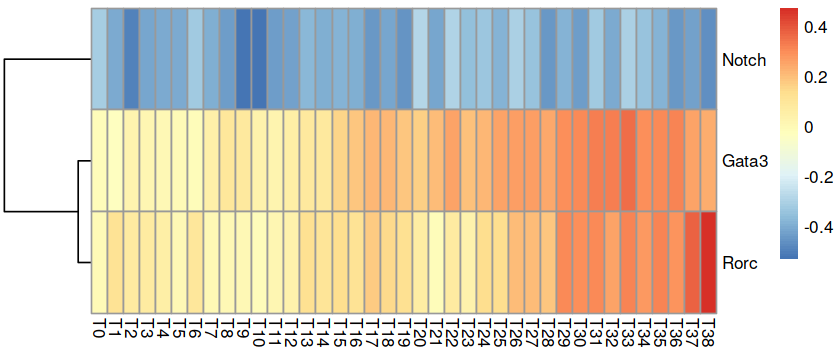

In [240]:
o(7,3)
pheatmap(gsva.result.fl, cluster_cols = F)

### aucell analysis

In [241]:
library("AUCell")
cells_rankings <- AUCell_buildRankings(as.matrix(expr), plotStats=F)
aucell.result.fl <- getAUC(AUCell_calcAUC(gs2genes, cells_rankings))


write.csv(aucell.result.fl, file='AUCell_fl_gata3-rorc-notch.csv')

Quantiles for the number of genes detected by cell: 
(Non-detected genes are shuffled at the end of the ranking. Keep it in mind when choosing the threshold for calculating the AUC).



    min      1%      5%     10%     50%    100% 
3853.00 3862.88 3942.00 4042.80 4817.00 5516.00 


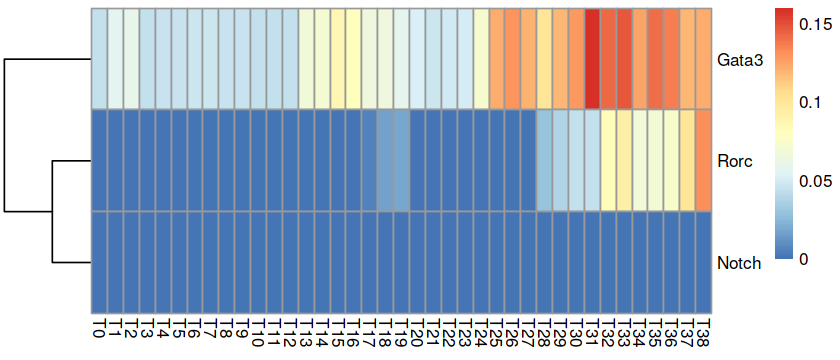

In [242]:
o(7,3)

pheatmap(aucell.result.fl, cluster_cols = F)